In [1]:
import pandas as pd
df = pd.read_csv('BigMart_Sales.csv')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna
# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)


In [3]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.shape

(8523, 12)

In [5]:
df.info()

# 5 are numericals
# others categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
print(df.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [7]:
mean_weight = df['Item_Weight'].mean()
mean_weight
df['Item_Weight'] = df['Item_Weight'].fillna(mean_weight)
df['Item_Weight'].isnull().sum()

0

In [8]:
mode_oz = df['Outlet_Size'].mode()[0]
mode_oz
df['Outlet_Size'] = df['Outlet_Size'].fillna(mode_oz)
df['Outlet_Size'].isnull().sum()

0

In [9]:
print(df.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [10]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

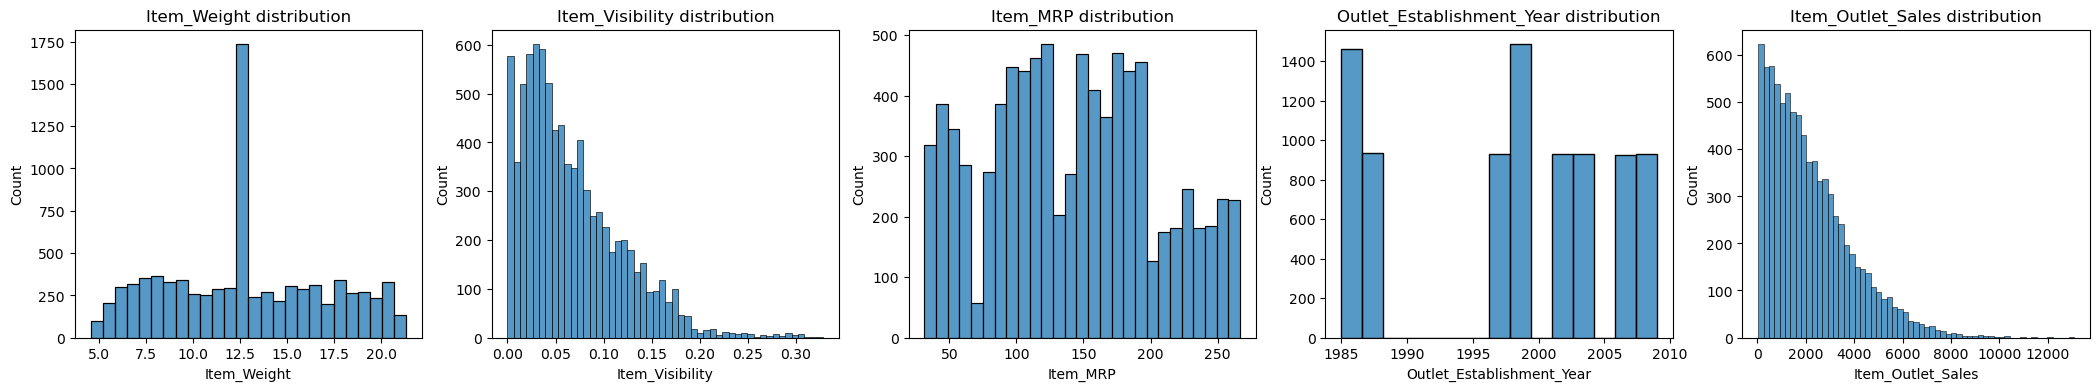

In [11]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

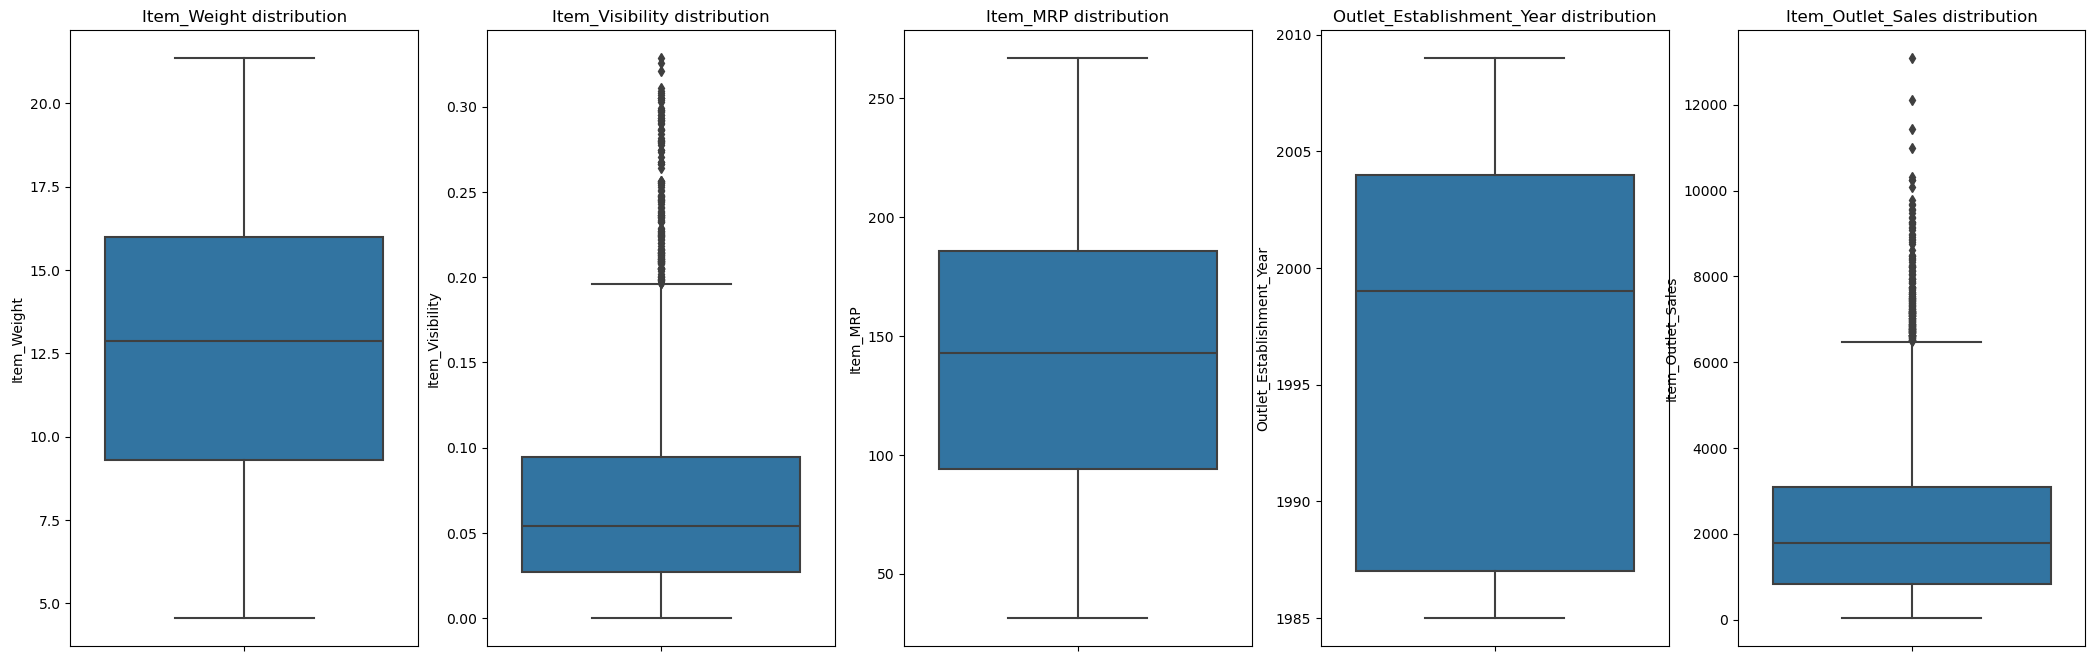

In [12]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

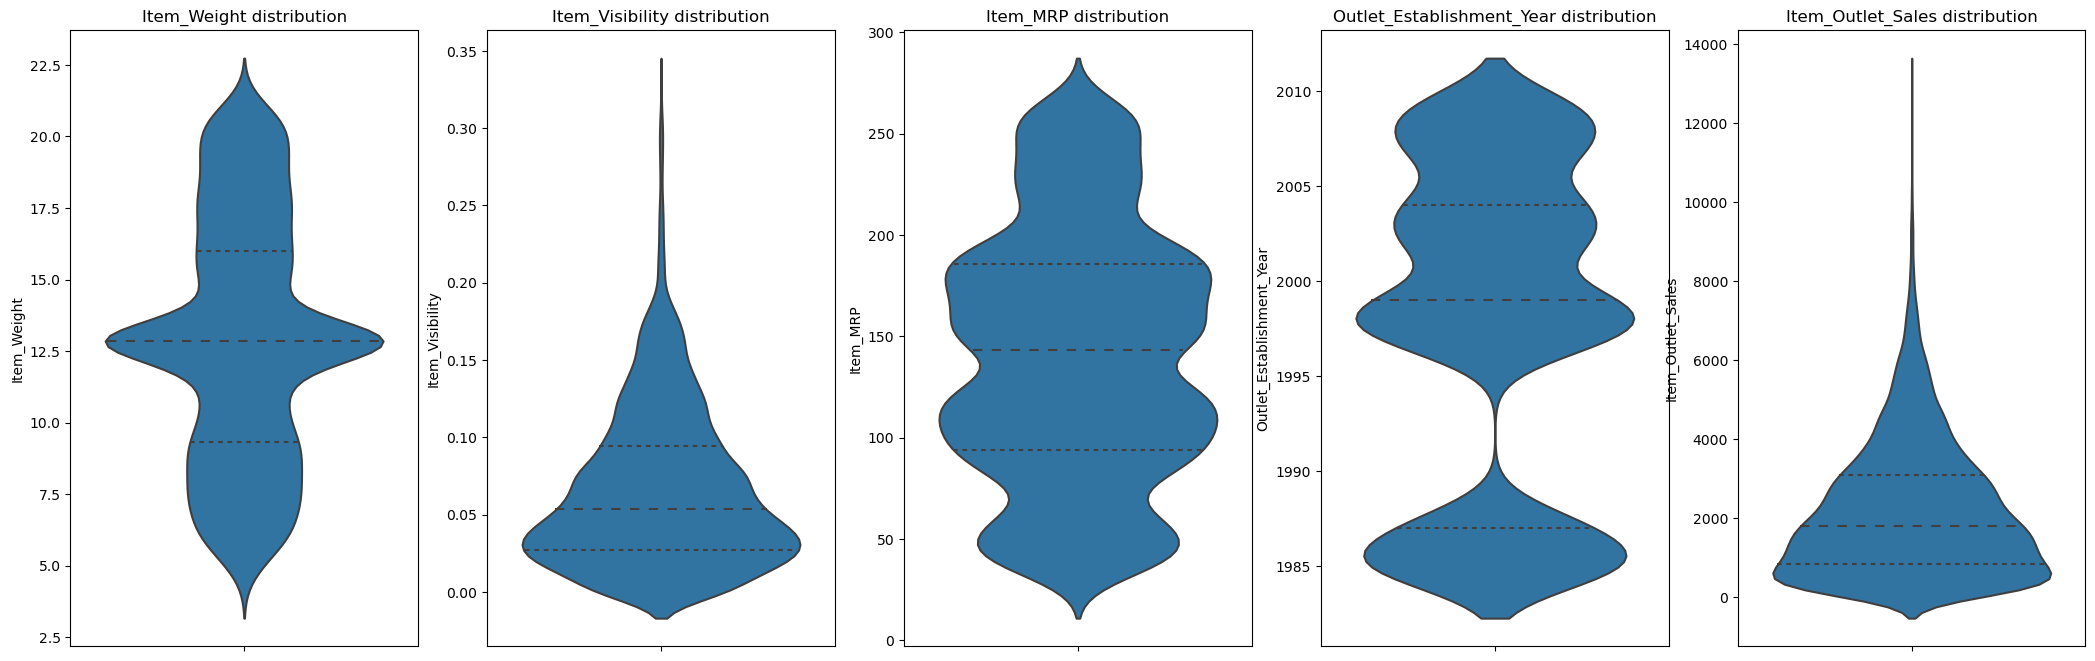

In [13]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_cols):
    sns.violinplot(data=df, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')

In [14]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols


['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [15]:
categorical_cols_to_display = [ 
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{df[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Outlet_Size
Medium    5203
Small     2388
High       932
Name: count, dtype: int64
------------

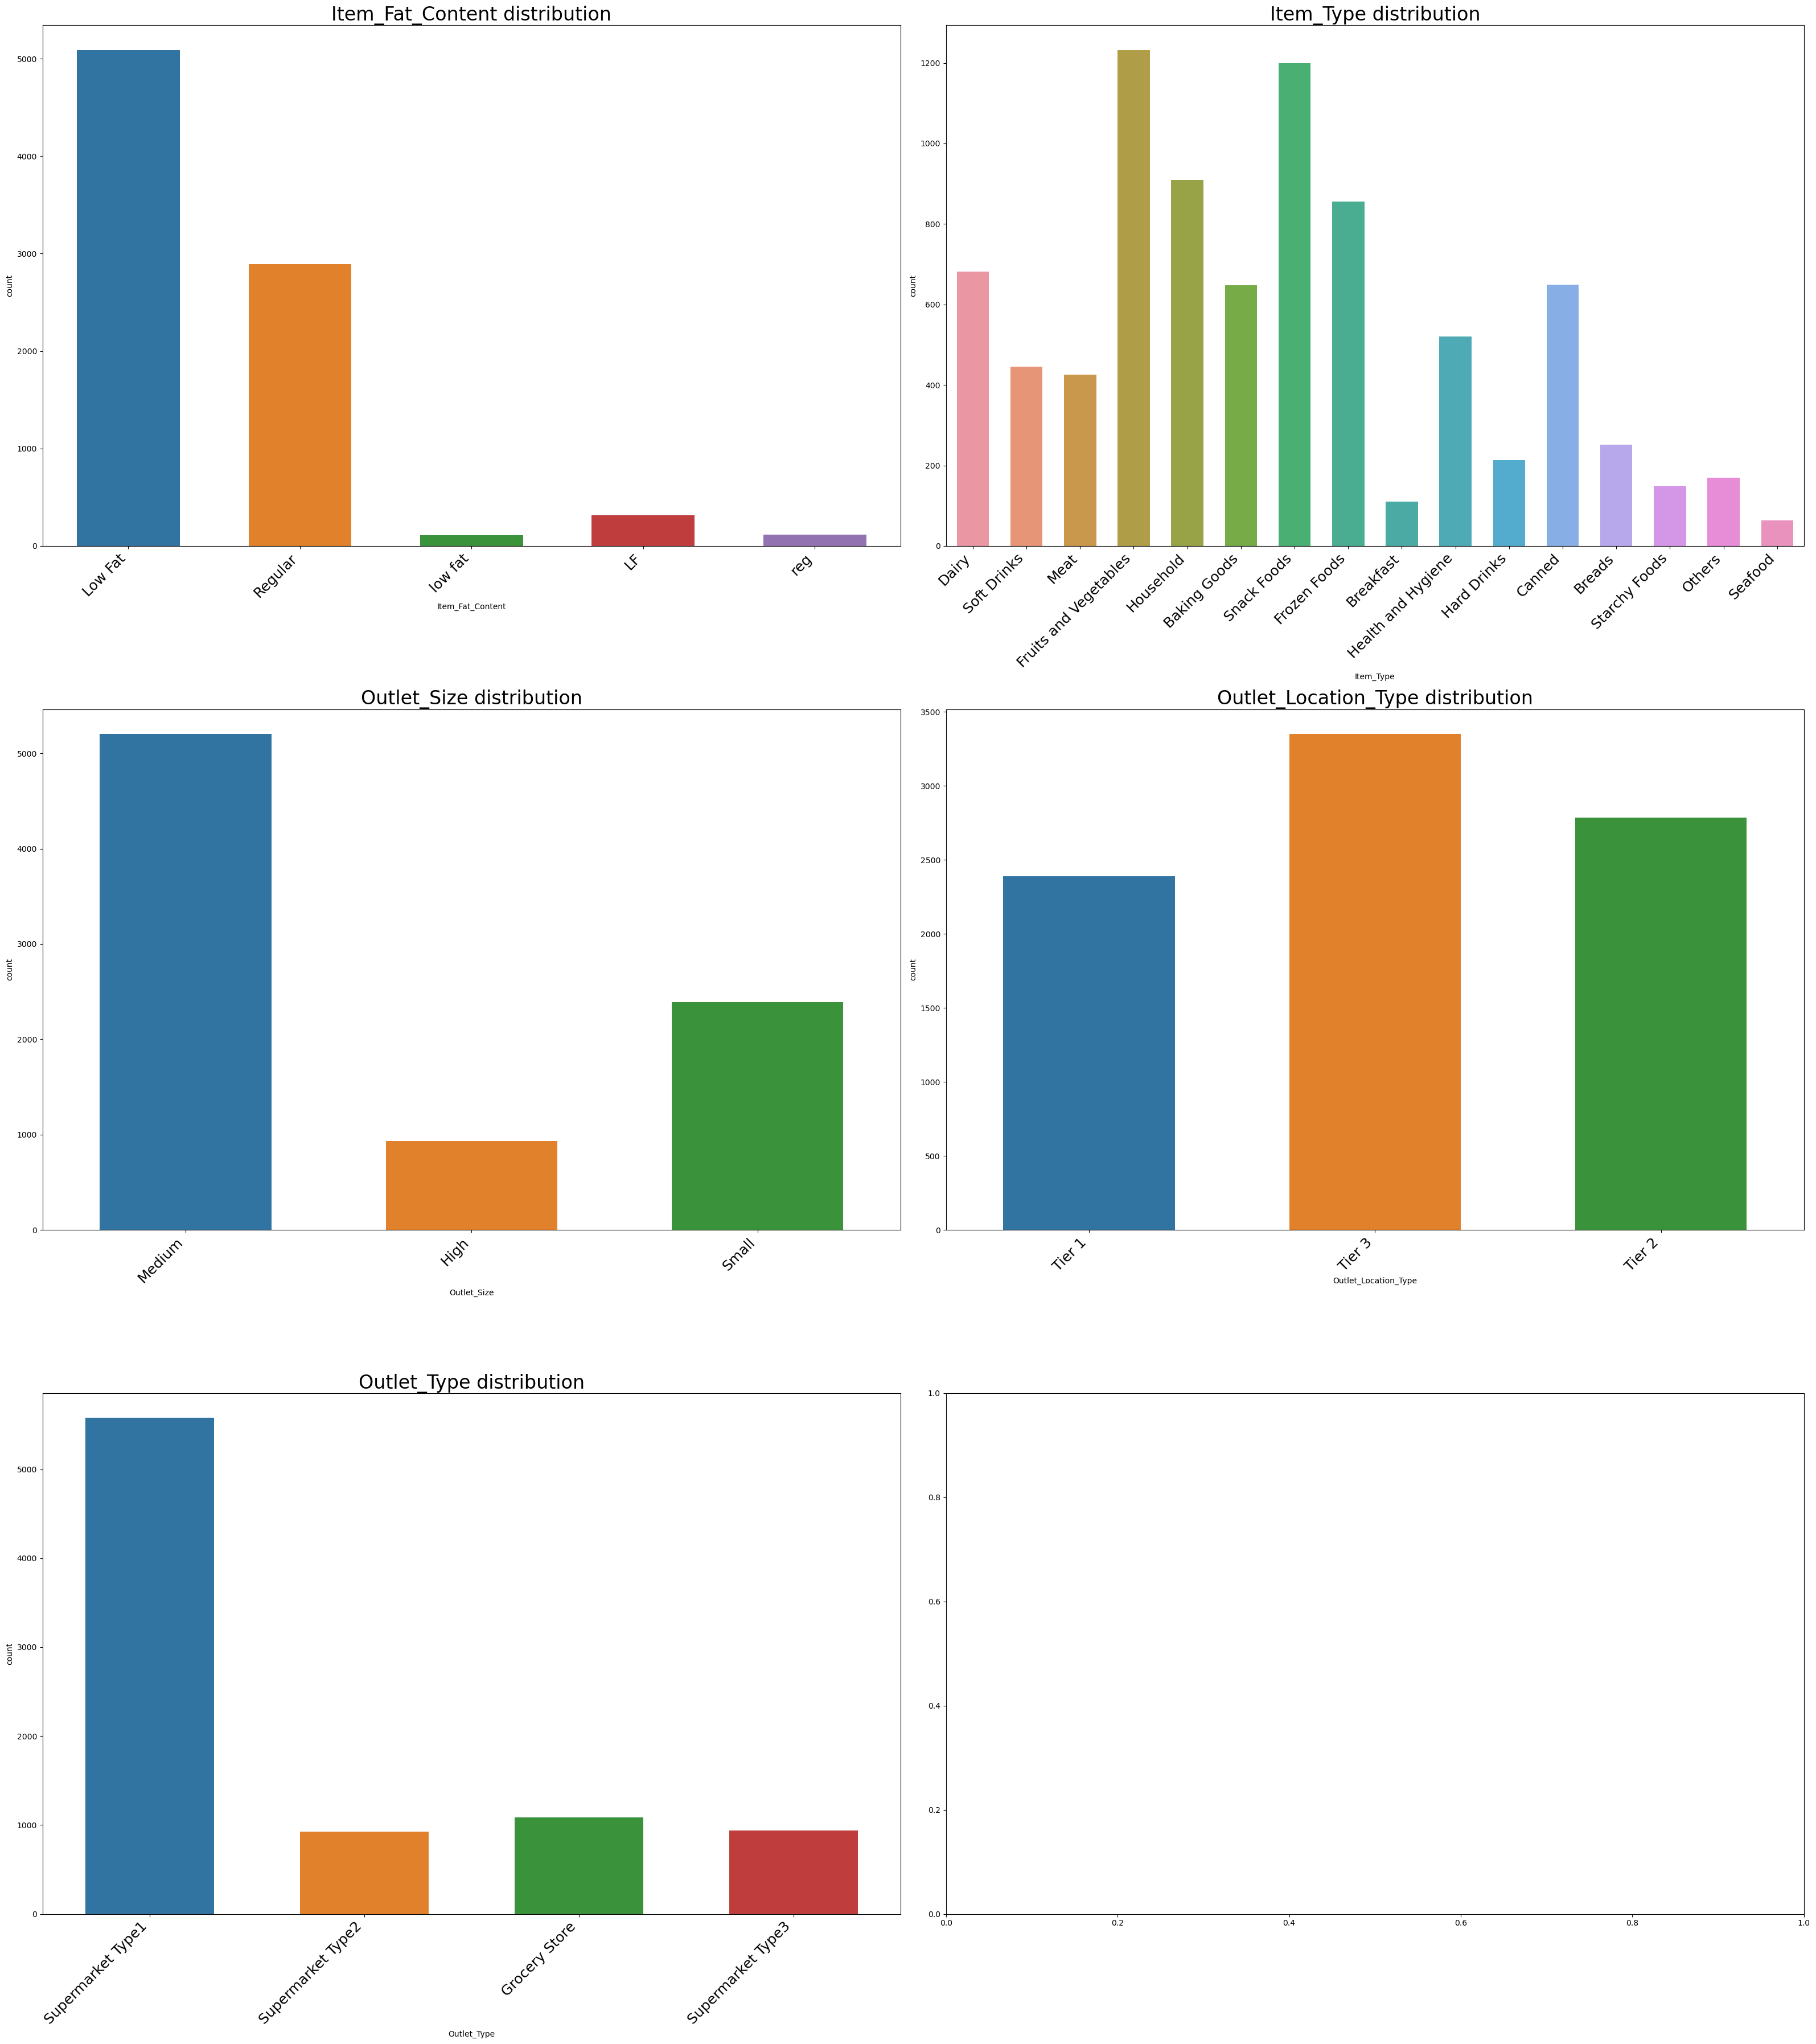

In [16]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=df, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

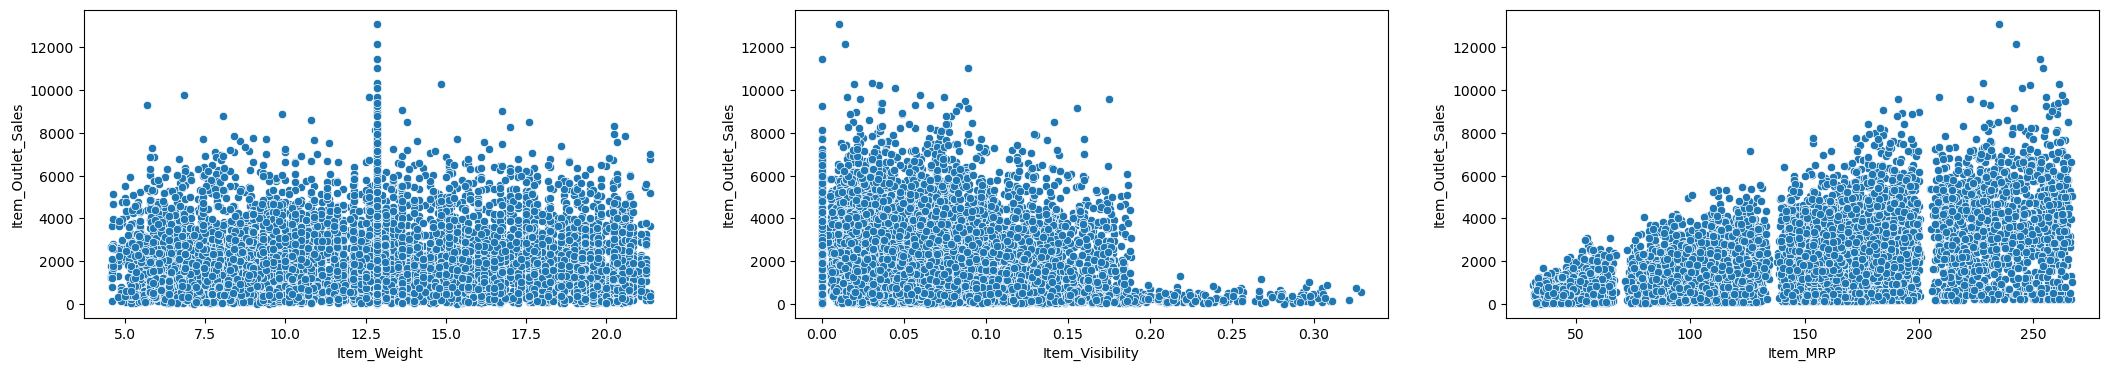

In [17]:
target = "Item_Outlet_Sales"
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=df,x=col, y=target, ax=ax[index])
    #ax[index].set_title(f'{col} distribution')

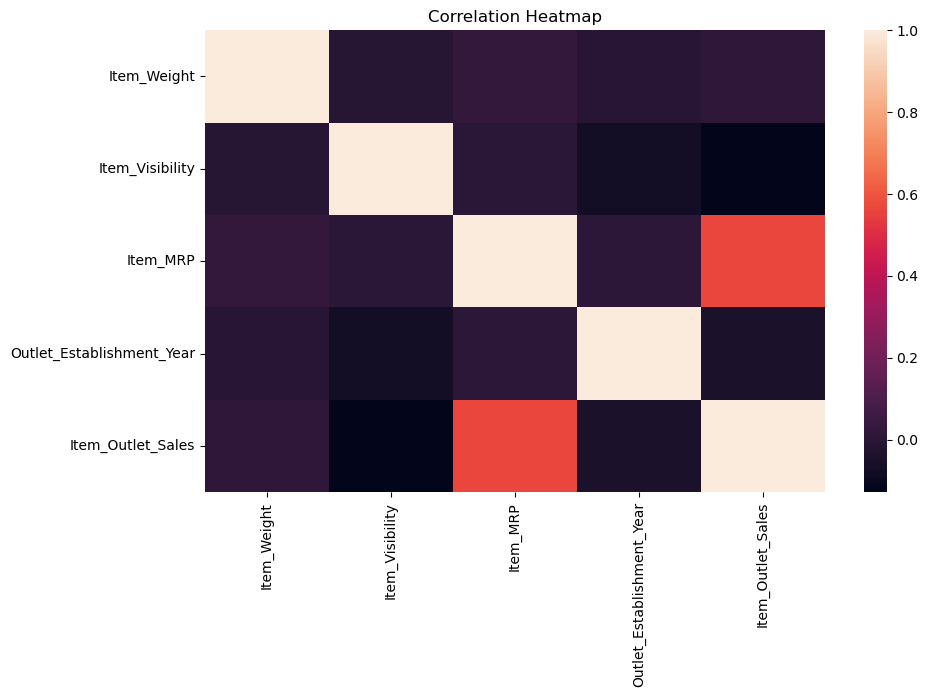

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numeric columns
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap')
plt.show()


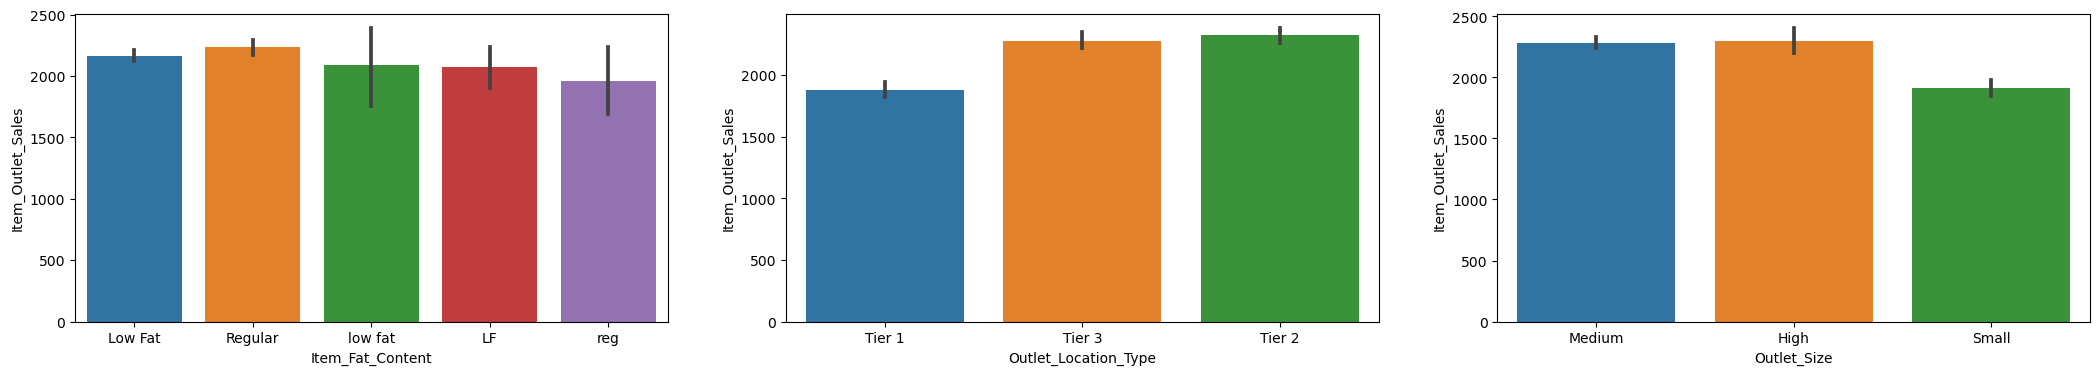

In [19]:
target = "Item_Outlet_Sales"
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size']):
    sns.barplot(data=df,x=col, y=target, ax=ax[index])


In [20]:
def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(df, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)


Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


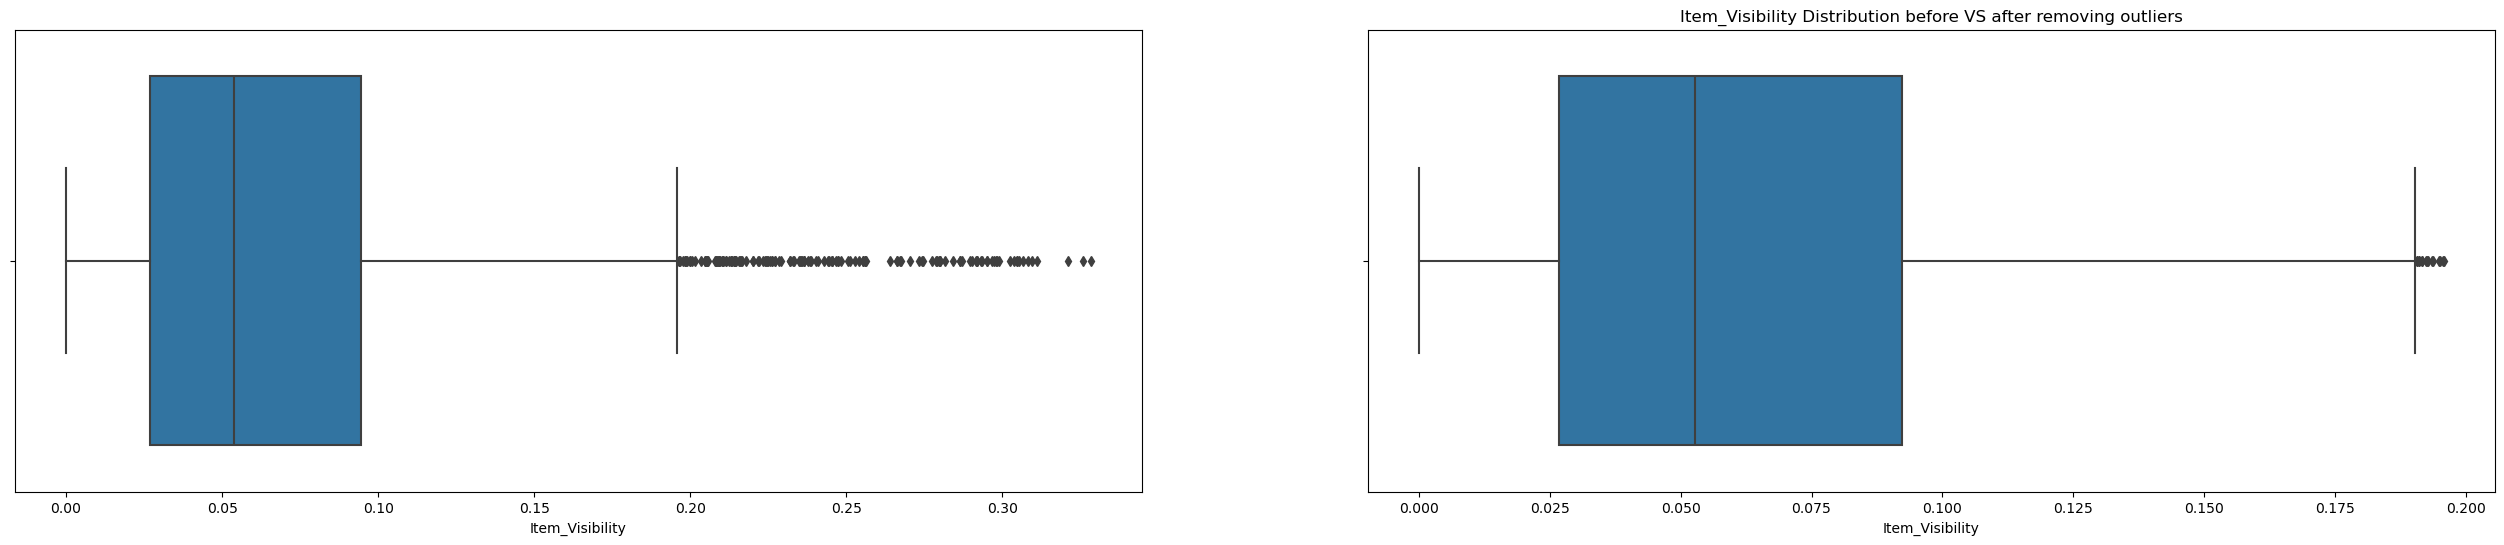

In [21]:

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=df['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
df = df[(df['Item_Visibility'] > lower) & (df['Item_Visibility'] < upper)] #train

sns.boxplot(x=df['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


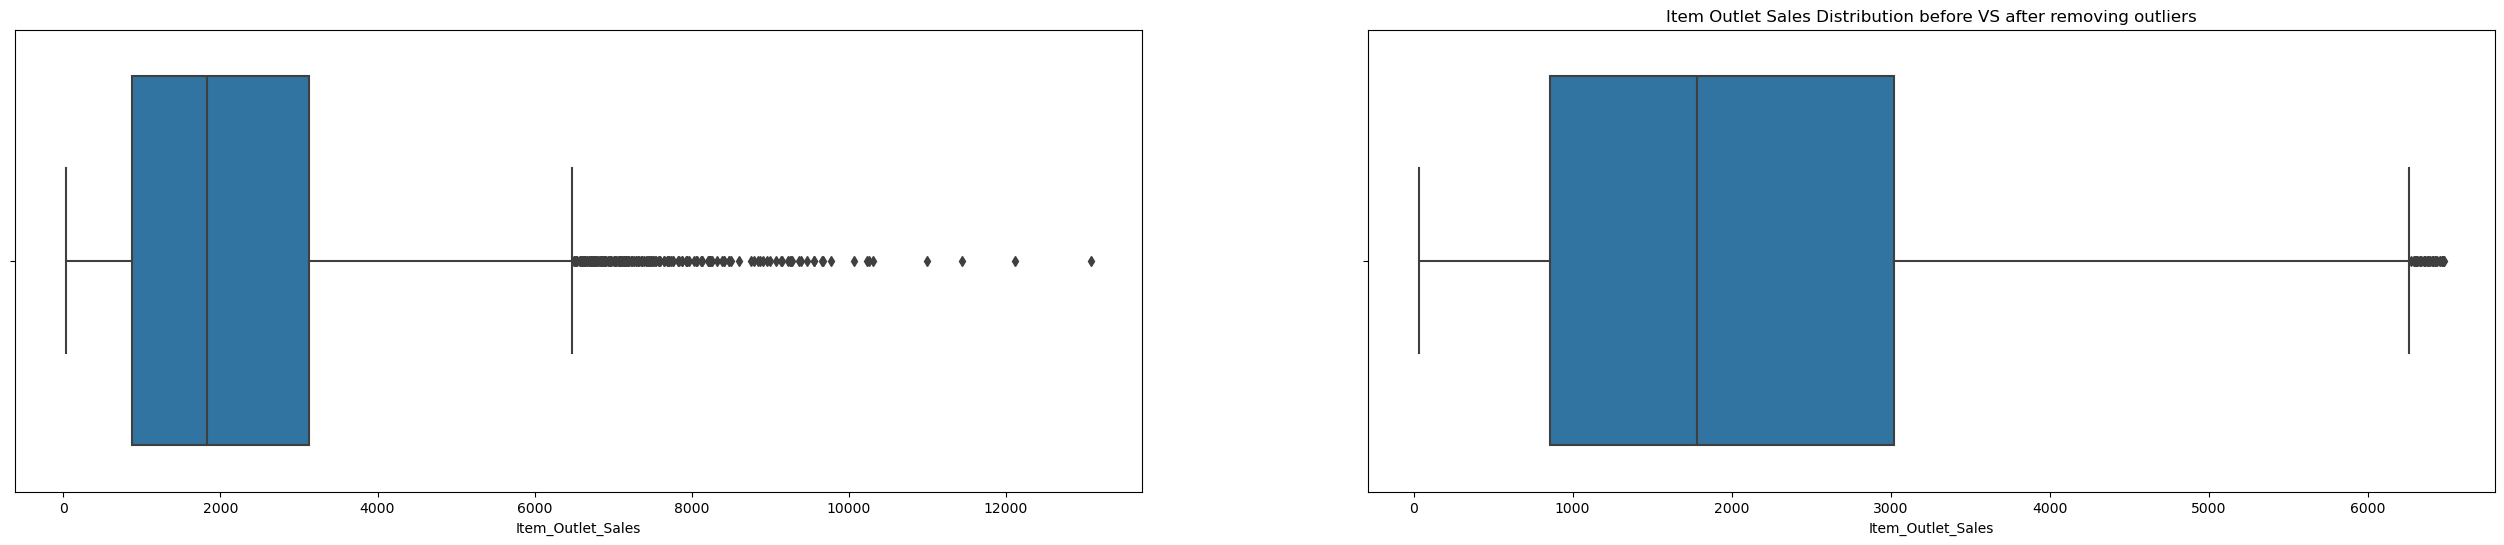

In [22]:
upper, lower = detect_outliers(df, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=df['Item_Outlet_Sales'], ax=ax[0])

# removing outliers using the same function
df = df[(df['Item_Outlet_Sales'] > lower) & (df['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=df['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()


<Axes: xlabel='Item_Fat_Content', ylabel='count'>

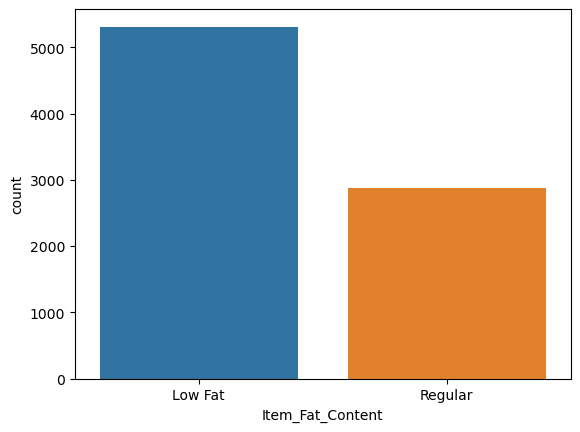

In [23]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].map({
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'Regular': 'Regular',
    'reg': 'Regular'
})
sns.countplot(x=df['Item_Fat_Content'])

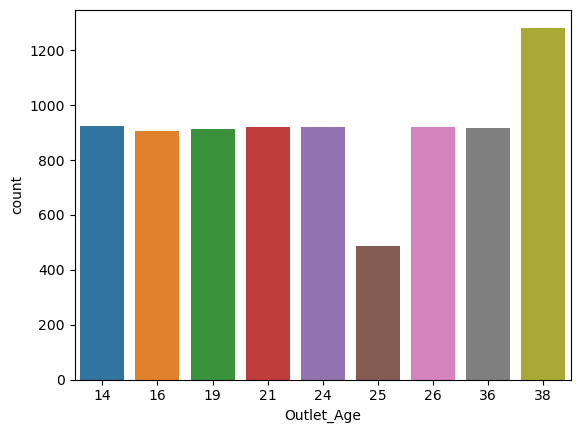

In [24]:
df['Outlet_Age'] = 2023 - df['Outlet_Establishment_Year']
del df['Outlet_Establishment_Year']
sns.countplot(x=df['Outlet_Age']);

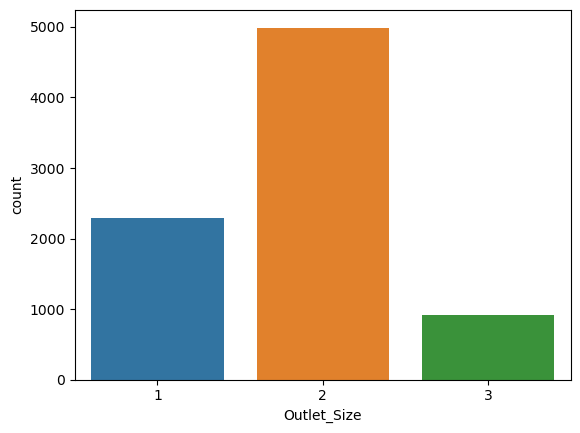

In [25]:
df['Outlet_Size'] = df['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)


sns.countplot(x=df['Outlet_Size']);


<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

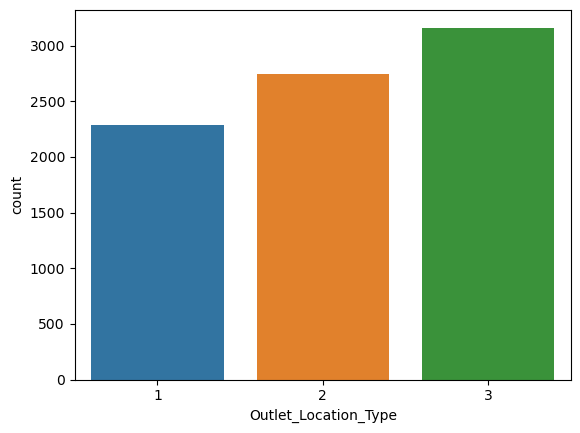

In [26]:
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str[-1:].astype(int)

sns.countplot(x=df['Outlet_Location_Type'])

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

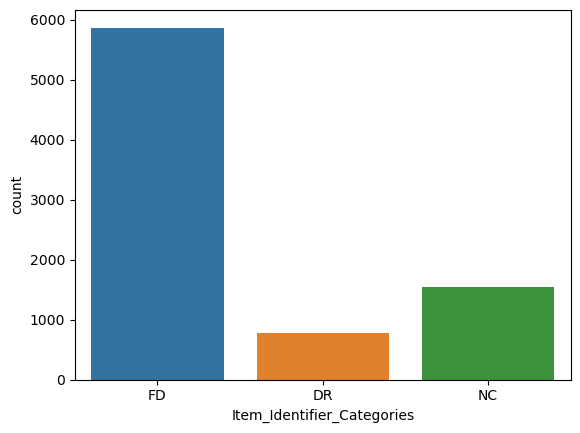

In [27]:
df['Item_Identifier_Categories'] = df['Item_Identifier'].str[0:2] #.astype(int)
sns.countplot(x=df['Item_Identifier_Categories'])

In [28]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380,24,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,3,Supermarket Type2,443.4228,14,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700,24,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,Grocery Store,732.3800,25,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,3,3,Supermarket Type1,994.7052,36,NC


In [29]:
encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    df[feature] = encoder.fit_transform(df[feature])
   

df.shape

(8193, 13)

In [30]:
df


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.300,0,0.016047,Dairy,249.8092,OUT049,2,0,1,3735.1380,24,FD
1,DRC01,5.920,1,0.019278,Soft Drinks,48.2692,OUT018,2,2,2,443.4228,14,DR
2,FDN15,17.500,0,0.016760,Meat,141.6180,OUT049,2,0,1,2097.2700,24,FD
3,FDX07,19.200,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,2,0,732.3800,25,FD
4,NCD19,8.930,0,0.000000,Household,53.8614,OUT013,3,2,1,994.7052,36,NC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0,0.056783,Snack Foods,214.5218,OUT013,3,2,1,2778.3834,36,FD
8519,FDS36,8.380,1,0.046982,Baking Goods,108.1570,OUT045,2,1,1,549.2850,21,FD
8520,NCJ29,10.600,0,0.035186,Health and Hygiene,85.1224,OUT035,1,1,1,1193.1136,19,NC
8521,FDN46,7.210,1,0.145221,Snack Foods,103.1332,OUT018,2,2,2,1845.5976,14,FD


In [31]:
df.drop(labels=['Item_Identifier'], axis=1, inplace=True)

In [32]:

df.drop(labels=['Outlet_Identifier'], axis=1, inplace=True)

In [33]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,9.30,0,0.016047,Dairy,249.8092,2,0,1,3735.1380,24,FD
1,5.92,1,0.019278,Soft Drinks,48.2692,2,2,2,443.4228,14,DR
2,17.50,0,0.016760,Meat,141.6180,2,0,1,2097.2700,24,FD
3,19.20,1,0.000000,Fruits and Vegetables,182.0950,2,2,0,732.3800,25,FD
4,8.93,0,0.000000,Household,53.8614,3,2,1,994.7052,36,NC


In [34]:
unique_values = df['Item_Type'].unique()

# Print the unique values
print(unique_values)

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


In [35]:
from sklearn.preprocessing import LabelEncoder

# Assuming your dataset is loaded into a pandas DataFrame called 'df'
label_encoder = LabelEncoder()

# Apply Label Encoding to 'Item_Type' column
df['Item_Type_Encoded'] = label_encoder.fit_transform(df['Item_Type'])

# Print the encoded values
print(df[['Item_Type', 'Item_Type_Encoded']].head())


               Item_Type  Item_Type_Encoded
0                  Dairy                  4
1            Soft Drinks                 14
2                   Meat                 10
3  Fruits and Vegetables                  6
4              Household                  9


In [36]:
unique_values = df['Item_Type'].unique()

# Print the unique values
print(unique_values)

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


In [37]:
unique_values = df['Item_Type_Encoded'].unique()

# Print the unique values
print(unique_values)

[ 4 14 10  6  9  0 13  5  2  8  7  3  1 15 11 12]


In [38]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories,Item_Type_Encoded
0,9.30,0,0.016047,Dairy,249.8092,2,0,1,3735.1380,24,FD,4
1,5.92,1,0.019278,Soft Drinks,48.2692,2,2,2,443.4228,14,DR,14
2,17.50,0,0.016760,Meat,141.6180,2,0,1,2097.2700,24,FD,10
3,19.20,1,0.000000,Fruits and Vegetables,182.0950,2,2,0,732.3800,25,FD,6
4,8.93,0,0.000000,Household,53.8614,3,2,1,994.7052,36,NC,9


In [39]:
df.shape

(8193, 12)

In [40]:
from sklearn.preprocessing import LabelEncoder

# Assuming your dataset is loaded into a pandas DataFrame called 'df'
label_encoder = LabelEncoder()

# Apply Label Encoding to 'Item_Identifier_Categories' column
df['Item_Identifier_Categories_Encoded'] = label_encoder.fit_transform(df['Item_Identifier_Categories'])

# Print the encoded values
print(df[['Item_Identifier_Categories', 'Item_Identifier_Categories_Encoded']].head())


  Item_Identifier_Categories  Item_Identifier_Categories_Encoded
0                         FD                                   1
1                         DR                                   0
2                         FD                                   1
3                         FD                                   1
4                         NC                                   2


In [41]:
df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories,Item_Type_Encoded,Item_Identifier_Categories_Encoded
0,9.300,0,0.016047,Dairy,249.8092,2,0,1,3735.1380,24,FD,4,1
1,5.920,1,0.019278,Soft Drinks,48.2692,2,2,2,443.4228,14,DR,14,0
2,17.500,0,0.016760,Meat,141.6180,2,0,1,2097.2700,24,FD,10,1
3,19.200,1,0.000000,Fruits and Vegetables,182.0950,2,2,0,732.3800,25,FD,6,1
4,8.930,0,0.000000,Household,53.8614,3,2,1,994.7052,36,NC,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0,0.056783,Snack Foods,214.5218,3,2,1,2778.3834,36,FD,13,1
8519,8.380,1,0.046982,Baking Goods,108.1570,2,1,1,549.2850,21,FD,0,1
8520,10.600,0,0.035186,Health and Hygiene,85.1224,1,1,1,1193.1136,19,NC,8,2
8521,7.210,1,0.145221,Snack Foods,103.1332,2,2,2,1845.5976,14,FD,13,1


In [42]:
# Drop 'Item_Identifier_Categories' and 'Item_Type' columns
df = df.drop(columns=['Item_Identifier_Categories', 'Item_Type'])
df.shape


(8193, 11)

In [43]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Type_Encoded,Item_Identifier_Categories_Encoded
0,9.30,0,0.016047,249.8092,2,0,1,3735.1380,24,4,1
1,5.92,1,0.019278,48.2692,2,2,2,443.4228,14,14,0
2,17.50,0,0.016760,141.6180,2,0,1,2097.2700,24,10,1
3,19.20,1,0.000000,182.0950,2,2,0,732.3800,25,6,1
4,8.93,0,0.000000,53.8614,3,2,1,994.7052,36,9,2


In [44]:
df.shape

(8193, 11)

In [45]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Type_Encoded,Item_Identifier_Categories_Encoded
0,9.30,0,0.016047,249.8092,2,0,1,3735.1380,24,4,1
1,5.92,1,0.019278,48.2692,2,2,2,443.4228,14,14,0
2,17.50,0,0.016760,141.6180,2,0,1,2097.2700,24,10,1
3,19.20,1,0.000000,182.0950,2,2,0,732.3800,25,6,1
4,8.93,0,0.000000,53.8614,3,2,1,994.7052,36,9,2


In [46]:
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Type_Encoded,Item_Identifier_Categories_Encoded
6745,9.50,0,0.085223,189.2872,2,0,1,24,7,0
6168,11.80,0,0.113505,186.8924,2,0,1,24,14,0
5390,17.60,0,0.018944,237.3590,2,1,1,21,8,2
3357,12.15,0,0.026011,119.1440,2,1,1,16,15,1
8241,10.80,0,0.097806,73.9380,2,2,0,25,7,0


In [49]:
X_train.shape

(6554, 10)

In [50]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)
rand_forest_predictions = rand_forest_model.predict(X_test)
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

Training score  : 0.9343058179827438
Test score      : 0.5142632353478711
RandomForest RMSE  	       ----> 1057.9904570881029
RandomForest R2 Score       ----> 0.5142632353478711


In [55]:
from sklearn.ensemble import RandomForestRegressor

rand_forest_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')
rand_forest_model.fit(X_train, y_train)
rand_forest_predictions = rand_forest_model.predict(X_test)
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(rand_forest_model, X_train, y_train, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", cross_val_scores.mean())


Training score  : 0.6587069843581175
Test score      : 0.5719354867555626
RandomForest RMSE  	       ----> 993.1980897873956
RandomForest R2 Score       ----> 0.5719354867555626
Cross-validation scores: [0.56742347 0.55974614 0.59845861 0.55355118 0.58693786]
Average cross-validation score: 0.5732234521902313


In [51]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost Training score  : 0.8508136275125938
XGBoost Test score      : 0.47082122546861505
XGBoost RMSE  	   ----> 1104.2882996252265
XGBoost R2 Score   ----> 0.47082122546861505


In [52]:
import joblib
joblib.dump(rand_forest_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math

# Initialize the Linear Regression model
linear_reg_model = LinearRegression()

# Fit the model on the training data
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test data
linear_reg_predictions = linear_reg_model.predict(X_test)

# Print the training and test scores (R^2 scores)
print('Training score  : {}'.format(linear_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(linear_reg_model.score(X_test, y_test)))

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
linear_reg_mse = mean_squared_error(y_test , linear_reg_predictions)
linear_reg_rmse = math.sqrt(linear_reg_mse)

# Calculate the R^2 score (coefficient of determination)
linear_reg_r2 = r2_score(y_test, linear_reg_predictions)

# Print the evaluation metrics
print('Linear Regression RMSE  \t       ----> {}'.format(linear_reg_rmse))
print('Linear Regression R2 Score       ----> {}'.format(linear_reg_r2))


Training score  : 0.4870673618462774
Test score      : 0.4825135778184364
Linear Regression RMSE  	       ----> 1092.0203766017567
Linear Regression R2 Score       ----> 0.4825135778184364
